# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

In [1]:
!pip install icrawler

In [2]:
import os
import shutil
import random
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler

### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [3]:
import os, time, random
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler

def download_images(keyword, folder, n_total=100, engines=('google','bing')):
    """
    Versão mais robusta:
    - tenta Google primeiro, se falhar tenta Bing
    - captura exceções do crawl e faz retries
    - usa parser_threads=1 (menos propenso a erros de parser)
    - reduz batch se houver repetidas falhas
    """
    os.makedirs(folder, exist_ok=True)

    def count_files(p):
        try:
            return len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
        except Exception:
            return 0

    downloaded = count_files(folder)
    remaining = n_total - downloaded

    if remaining <= 0:
        print(f"Já existem {downloaded} arquivos em {folder}. Nada a fazer.")
        return

    print(f"Começando download: alvo {n_total} imagens -> já {downloaded} existentes, faltam {remaining}")

    # parâmetros de tentativa
    max_attempts_per_engine = 3

    for engine in engines:
        attempt = 0
        # enquanto faltar imagens e tentativas ainda disponíveis
        while downloaded < n_total and attempt < max_attempts_per_engine:
            try:
                # reduzir threads do parser para evitar erros tipo 'NoneType' do parser
                if engine == 'google':
                    crawler = GoogleImageCrawler(storage={'root_dir': folder},
                                                 feeder_threads=1, parser_threads=1, downloader_threads=4)
                else:
                    crawler = BingImageCrawler(storage={'root_dir': folder},
                                               feeder_threads=1, parser_threads=1, downloader_threads=4)

                # tenta baixar apenas o que falta
                remaining = n_total - downloaded
                # se já falhou antes várias vezes, baixe em blocos menores
                max_num = min(remaining, 100)  # ajustável
                print(f"[{engine}] tentativa {attempt+1}: pedindo {max_num} imagens (offset {downloaded})")
                crawler.crawl(keyword=keyword, max_num=max_num, file_idx_offset=downloaded)

                # reconta
                time.sleep(0.5)
                downloaded = count_files(folder)
                remaining = n_total - downloaded
                print(f"[{engine}] status: downloaded {downloaded}/{n_total}")

                # se baixou tudo, break
                if downloaded >= n_total:
                    print("Download complete!")
                    return

                # se não baixou nada nessa tentativa, aumentar attempt e talvez reduzir bloco
                attempt += 1

            except Exception as e:
                print(f"[{engine}] Erro na tentativa {attempt+1}: {e}")
                attempt += 1
                # aguarda um pouco antes de tentar novamente
                time.sleep(2 + attempt)
                # se já tentou muito, reduza o bloco solicitado para evitar parsing pesado
                if attempt >= 2:
                    print(f"[{engine}] reduzindo bloco de download e tentando novamente.")
                    # força próximo max_num menor na próxima iteração
                    # (o min() acima já cuida disso se você reduzir n_total ou downloaded)
                    pass

        # se esgotaram as tentativas deste engine, passa pro próximo engine (fallback)
        print(f"[{engine}] esgotou tentativas ou não completou. Próximo engine/fallback.")

    # depois de tentar todos os engines:
    downloaded = count_files(folder)
    if downloaded < n_total:
        print(f"Atenção: após tentativas, baixadas {downloaded}/{n_total} imagens. Pode ser bloqueio ou falta de resultados.")
    else:
        print("Download complete!")


In [4]:
tema = "herois"
classe1 = "saitama"
classe2 = "super man"

search_terms = {
    classe1: f"personagem {classe1}",
    classe2: f"personagem {classe2}"
}




base_folder = f"data/{tema}"

for label, term in search_terms.items():
    print(f"Iniciando download para a classe: {label}...")

    # A variável 'label' agora define o nome da pasta
    download_images(term, f"{base_folder}/{label}", n_total=100)

print("\nTodos os downloads foram concluídos.")

Iniciando download para a classe: saitama...
Começando download: alvo 100 imagens -> já 0 existentes, faltam 100
[google] tentativa 1: pedindo 100 imagens (offset 0)


Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable
Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable


[google] status: downloaded 0/100
[google] tentativa 2: pedindo 100 imagens (offset 0)
[google] status: downloaded 0/100
[google] tentativa 3: pedindo 100 imagens (offset 0)


Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable


[google] status: downloaded 0/100
[google] esgotou tentativas ou não completou. Próximo engine/fallback.
[bing] tentativa 1: pedindo 100 imagens (offset 0)


ERROR:downloader:Response status code 404, file https://vignette2.wikia.nocookie.net/p__/images/2/2d/One_Punch.Man.600.1930270.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/6/67663/6500908-6648607198-5293-.jpg
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 2
ERROR:downloader:Response status code 404, file https://vignette.wikia.nocookie.net/super-poderes/images/8/82/656720.jpg
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664

[bing] status: downloaded 53/100
[bing] tentativa 2: pedindo 47 imagens (offset 53)


ERROR:downloader:Response status code 404, file https://vignette2.wikia.nocookie.net/p__/images/2/2d/One_Punch.Man.600.1930270.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/6/67663/6500908-6648607198-5293-.jpg
ERROR:downloader:Response status code 404, file https://vignette.wikia.nocookie.net/super-poderes/images/8/82/656720.jpg
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664

[bing] status: downloaded 93/100
[bing] tentativa 3: pedindo 7 imagens (offset 93)


ERROR:downloader:Response status code 404, file https://vignette2.wikia.nocookie.net/p__/images/2/2d/One_Punch.Man.600.1930270.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/6/67663/6500908-6648607198-5293-.jpg
ERROR:downloader:Response status code 404, file https://vignette.wikia.nocookie.net/super-poderes/images/8/82/656720.jpg
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file http://pm1.narvii.com/6233/242efa9cb79664cc81c35b88a90a8156b7d01d31_00.jpg, error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), remaining retry times: 1


[bing] status: downloaded 100/100
Download complete!
Iniciando download para a classe: super man...
Começando download: alvo 100 imagens -> já 0 existentes, faltam 100
[google] tentativa 1: pedindo 100 imagens (offset 0)


Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable
Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable


[google] status: downloaded 0/100
[google] tentativa 2: pedindo 100 imagens (offset 0)
[google] status: downloaded 0/100
[google] tentativa 3: pedindo 100 imagens (offset 0)


Exception in thread parser-001:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/icrawler/parser.py", line 93, in worker_exec
    for task in self.parse(response, **kwargs):
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not iterable


[google] status: downloaded 0/100
[google] esgotou tentativas ou não completou. Próximo engine/fallback.
[bing] tentativa 1: pedindo 100 imagens (offset 0)


ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/11174/111743204/8945480-supermanofchina.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/11111/111113340/9074671-00_super-man_06_p.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/scale_medium/11111/111113340/9074767-00_super-man_01.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/square_small/11111/111113340/9074716-3921510313-2c6cf.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/scale_medium/11155/111550463/9177110-1149491.jpg


[bing] status: downloaded 75/100
[bing] tentativa 2: pedindo 25 imagens (offset 75)


ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/11174/111743204/8945480-supermanofchina.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/square_small/11111/111113340/9074716-3921510313-2c6cf.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/scale_medium/11111/111113340/9074767-00_super-man_01.jpg
ERROR:downloader:Response status code 403, file https://comicvine.gamespot.com/a/uploads/original/11111/111113340/9074671-00_super-man_06_p.jpg


[bing] status: downloaded 100/100
Download complete!

Todos os downloads foram concluídos.


In [5]:
from PIL import Image
import hashlib

def clean_downloads(folder, min_bytes=15000):
    seen = {}
    removed = 0
    for root, _, files in os.walk(folder):
        for f in files:
            p = os.path.join(root, f)
            try:
                if os.path.getsize(p) < min_bytes:
                    os.remove(p); removed += 1; continue
                # verificar se PIL consegue abrir
                im = Image.open(p); im.verify()
                # dedup
                h = hashlib.md5(open(p,'rb').read()).hexdigest()
                if h in seen:
                    os.remove(p); removed += 1
                else:
                    seen[h] = p
            except Exception:
                try:
                    os.remove(p); removed += 1
                except:
                    pass
    print(f"Limpeza finalizada. Arquivos removidos: {removed}")


### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [6]:
def split_train_val(root_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [7]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- 1. Definição da Classe Dataset Personalizada (COM DEBUG) ---
class AnimeDataset(Dataset):
    # ... (restante do código igual)

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Mapeamento de nome de pasta (classe) para índice numérico
        self.class_to_idx = {
            f'{classe1}': 0,
            f'{classe2}': 1
        }

        print(f"\n[DEBUG DATASET] Iniciando busca em: {self.root_dir}")

        # Preenche as listas de caminhos e rótulos
        for class_name, idx in self.class_to_idx.items():
            class_path = os.path.join(root_dir, class_name)

            if os.path.isdir(class_path):
                # Tenta listar os arquivos APENAS se o diretório existir
                try:
                    filenames = os.listdir(class_path)

                    # Filtra apenas arquivos (exclui pastas ocultas, etc.)
                    valid_files = [f for f in filenames if os.path.isfile(os.path.join(class_path, f))]

                    if len(valid_files) == 0:
                         print(f"[DEBUG DATASET] A pasta '{class_name}' está VAZIA. Caminho: {class_path}")
                         continue # Pula para a próxima classe

                    for filename in valid_files:
                        self.image_paths.append(os.path.join(class_path, filename))
                        self.labels.append(idx)

                    print(f"[DEBUG DATASET] Classe '{class_name}' adicionada com {len(valid_files)} imagens.")

                except Exception as e:
                    print(f"[DEBUG DATASET] ERRO de permissão/leitura em {class_path}. Erro: {e}")

            else:
                print(f"[DEBUG DATASET] Pasta de classe NÃO ENCONTRADA para '{class_name}'. Esperado em: {class_path}")

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        # Implementação de tratamento de erros com try-except
        try:
            # 1. Carregar a Imagem
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            # 2. Aplicar Transformações
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            # Em caso de erro (ex: arquivo corrompido, erro de leitura)
            print(f"Erro ao carregar imagem em {self.image_paths[idx]}. Erro: {e}")
            # Retorna um elemento aleatório para não quebrar o batching
            # Isso é uma solução simples; em produção, você pularia este item.
            # Aqui, tentamos uma solução para continuar o treinamento:

            # Escolhe um novo índice aleatório (que não seja o atual)
            new_idx = random.randint(0, len(self) - 1)
            if new_idx == idx:
                new_idx = (new_idx + 1) % len(self)

            return self.__getitem__(new_idx)


# --- 2. Definição das Transformações e Data Augmentation ---
def get_transforms(image_size=224):
    """Define as transformações para treino (com augmentation) e validação."""

    # Transformações para o conjunto de TREINO (com Data Augmentation)
    train_transforms = transforms.Compose([
        # Data Augmentation:
        transforms.Resize((image_size, image_size)), # Redimensiona para um tamanho padrão
        transforms.RandomRotation(15),             # Rotação aleatória de até 15 graus
        transforms.RandomHorizontalFlip(p=0.5),    # Flip horizontal aleatório
        transforms.ColorJitter(brightness=0.1, contrast=0.1), # Variações de cor/brilho

        # Conversão e Normalização (Essencial para pré-treinamento - ImageNet)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Transformações para o conjunto de VALIDAÇÃO/TESTE (SEM Data Augmentation)
    # Apenas redimensiona, converte e normaliza
    val_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms





In [8]:
# --- 3. Função de Implementação e Carregamento (DataLoader) ---
def create_dataloaders(root_dir, batch_size=32, image_size=224):
    """Cria e retorna os DataLoaders de Treino e Validação."""

    # 🚨 Modificação: A função create_dataloaders deve receber o caminho base do SPLIT.
    # Ex: /content/data/classes_split



    if root_dir.endswith('/'):
        root_dir = root_dir[:-1] # Remove barra final, se houver

    # Assume que a pasta de treino/validação está em {root_dir}/train e {root_dir}/val
    train_dir = os.path.join(root_dir, "train")
    val_dir = os.path.join(root_dir, "val")

    # --- NOVO: Verificação do ponto de partida ---
    print(f"\n[DEBUG LOADER] Verificando diretórios esperados:")
    print(f"[DEBUG LOADER] Treino: {train_dir}")
    print(f"[DEBUG LOADER] Validação: {val_dir}")

    if not os.path.isdir(train_dir) or not os.path.isdir(val_dir):
        print("ERRO CRÍTICO: Pastas 'train' e/ou 'val' não foram encontradas. O caminho base do split está incorreto.")
        print("Verifique se o seu 'root_dir' na chamada é a pasta que contém 'train' e 'val'.")
        return None, None
    # ---------------------------------------------

    train_transforms, val_transforms = get_transforms(image_size)

    try:
        # Cria os Datasets (aqui o erro num_samples=0 será detectado pelos prints internos)
        train_dataset = AnimeDataset(root_dir=train_dir, transform=train_transforms)
        val_dataset = AnimeDataset(root_dir=val_dir, transform=val_transforms)

        # O código a seguir só será executado se len(train_dataset) e len(val_dataset) > 0

        if len(train_dataset) == 0 or len(val_dataset) == 0:
             # Este raise agora será mais específico com a informação de debug
             raise ValueError("Dataset vazio. Verifique os prints de debug acima para saber qual pasta falhou.")

        # ... (Criação dos DataLoaders)

        print(f"Datasets carregados: Treino ({len(train_dataset)} imagens), Validação ({len(val_dataset)} imagens)")

        return train_dataloader, val_dataloader

    except Exception as e:
        # ... (Tratamento de erro existente)
        return None, None

In [9]:


# 1. Executar a Divisão do Dataset
# Esta chamada CRIA a pasta de saída: /content/data/classes_split
print("--- Passo 1: Executando a Divisão (SPLIT) dos dados ---")
split_train_val(
    root_dir=f'/content/data/{tema}',
    train_ratio=0.8,
    seed=42
)
print(f"Divisão concluída. Pasta /content/data/{tema}_split criada.")


# 2. Criar os DataLoaders a partir do diretório CORRETO (o que foi recém-criado)
print("\n--- Passo 2: Criando DataLoaders a partir do diretório SPLIT ---")
if __name__ == '__main__':
    TRAIN_LOADER, VAL_LOADER = create_dataloaders(
        root_dir=f"/content/data/{tema}_split", # Pasta que agora existe
        batch_size=32
    )

    if TRAIN_LOADER and VAL_LOADER:
        # Teste de iteração (só rodará se o tamanho do dataset for > 0)
        print("\nSucesso! Testando um batch de treino:")
        for images, labels in TRAIN_LOADER:
            print(f"Shape do batch de imagens (Batch Size, Channels, Height, Width): {images.shape}")
            print(f"Labels do batch: {labels}")
            break

--- Passo 1: Executando a Divisão (SPLIT) dos dados ---
saitama: 80 train, 20 val
super man: 80 train, 20 val
Divisão concluída. Pasta /content/data/herois_split criada.

--- Passo 2: Criando DataLoaders a partir do diretório SPLIT ---

[DEBUG LOADER] Verificando diretórios esperados:
[DEBUG LOADER] Treino: /content/data/herois_split/train
[DEBUG LOADER] Validação: /content/data/herois_split/val

[DEBUG DATASET] Iniciando busca em: /content/data/herois_split/train
[DEBUG DATASET] Classe 'saitama' adicionada com 80 imagens.
[DEBUG DATASET] Classe 'super man' adicionada com 80 imagens.

[DEBUG DATASET] Iniciando busca em: /content/data/herois_split/val
[DEBUG DATASET] Classe 'saitama' adicionada com 20 imagens.
[DEBUG DATASET] Classe 'super man' adicionada com 20 imagens.
Datasets carregados: Treino (160 imagens), Validação (40 imagens)


In [10]:
#!ls /content/data/classes


## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado.

In [11]:
import torch
import torch.nn as nn
from torchvision import models

def setup_model(num_classes=2, feature_extract=True):
    """
    Define e inicializa o modelo ResNet18 pré-treinado.

    Args:
        num_classes (int): O número de classes de saída .
        feature_extract (bool): Se True, congela os parâmetros do corpo do modelo.
    """

    # 1. Carregar o modelo ResNet18 pré-treinado no ImageNet
    model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    print("Modelo base ResNet18 carregado com pesos pré-treinados.")


    if feature_extract:
      for name, param in model_ft.named_parameters():
        param.requires_grad = False




    num_ftrs = model_ft.fc.in_features

    # Substituir a camada 'fc' por uma nova camada linear
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    print(f"Camada final (fc) modificada para {num_classes} classes.")

    return model_ft

if __name__ == '__main__':
    NUM_CLASSES = 2

    # 1. Inicializar o Modelo
    model = setup_model(num_classes=NUM_CLASSES, feature_extract=True)

    # 2. Mover o modelo para a GPU, se disponível
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 3. Testar o Modelo (Passar um tensor de dados pelo modelo)
    # Criamos um tensor simulando um batch de 32 imagens (cor: 3, tamanho: 224x224)
    dummy_input = torch.randn(32, 3, 224, 224).to(device)

    try:
        output = model(dummy_input)
        print(f"\nTeste de output do modelo realizado com sucesso.")
        print(f"Shape de saída (Batch Size, Classes): {output.shape}") # Deve ser [32, 2]
    except Exception as e:
        print(f"Erro ao passar dados de teste pelo modelo: {e}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


Modelo base ResNet18 carregado com pesos pré-treinados.
Camada final (fc) modificada para 2 classes.

Teste de output do modelo realizado com sucesso.
Shape de saída (Batch Size, Classes): torch.Size([32, 2])


## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.

Época 1/15 - Train Loss: 0.7199, Train Acc: 0.5687 - Val Loss: 0.6403, Val Acc: 0.5750
Época 2/15 - Train Loss: 0.5674, Train Acc: 0.7688 - Val Loss: 0.5337, Val Acc: 0.7500
Época 3/15 - Train Loss: 0.5048, Train Acc: 0.7875 - Val Loss: 0.4735, Val Acc: 0.8000
Época 4/15 - Train Loss: 0.4091, Train Acc: 0.8625 - Val Loss: 0.4484, Val Acc: 0.7750
Época 5/15 - Train Loss: 0.3697, Train Acc: 0.9062 - Val Loss: 0.4117, Val Acc: 0.8250
Época 6/15 - Train Loss: 0.3253, Train Acc: 0.9250 - Val Loss: 0.3912, Val Acc: 0.8750
Época 7/15 - Train Loss: 0.3433, Train Acc: 0.8750 - Val Loss: 0.3824, Val Acc: 0.8250
Época 8/15 - Train Loss: 0.2839, Train Acc: 0.9313 - Val Loss: 0.3556, Val Acc: 0.8500
Época 9/15 - Train Loss: 0.2680, Train Acc: 0.9500 - Val Loss: 0.3415, Val Acc: 0.8500
Época 10/15 - Train Loss: 0.2485, Train Acc: 0.9375 - Val Loss: 0.3376, Val Acc: 0.8500
Época 11/15 - Train Loss: 0.2263, Train Acc: 0.9625 - Val Loss: 0.3138, Val Acc: 0.9250
Época 12/15 - Train Loss: 0.2106, Train A

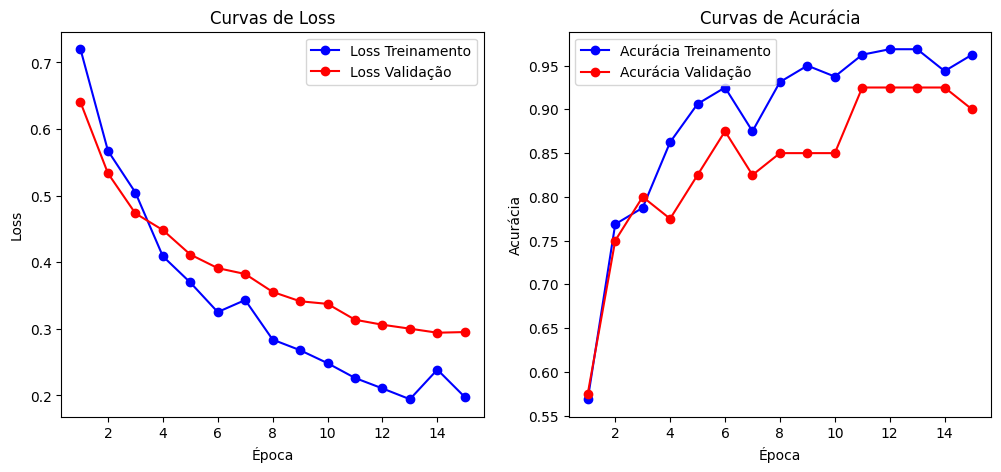

In [12]:
import os
import time
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {f'{classe1}': 0, f'{classe2}': 1}

        for class_name, idx in self.class_to_idx.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    fpath = os.path.join(class_path, filename)
                    if os.path.isfile(fpath):
                        self.image_paths.append(fpath)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

        except Exception as e:
            new_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(new_idx)

def get_transforms(image_size=224):
    train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transforms, val_transforms

def create_dataloaders(root_dir, batch_size=32, image_size=224):
    train_dir = os.path.join(root_dir, "train")
    val_dir = os.path.join(root_dir, "val")
    train_transforms, val_transforms = get_transforms(image_size)

    try:
        train_dataset = AnimeDataset(root_dir=train_dir, transform=train_transforms)
        val_dataset = AnimeDataset(root_dir=val_dir, transform=val_transforms)

        if len(train_dataset) == 0 or len(val_dataset) == 0:
             raise ValueError("Dataset vazio.")

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        return train_dataloader, val_dataloader

    except Exception as e:
        return None, None

def setup_model(num_classes=2, feature_extract=True):
    model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def train_model(model, dataloaders, criterion, optimizer, num_epochs=15):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # ---- SALVA O MELHOR MODELO ----
                torch.save(model.state_dict(), "best_model.pth")

        print(
            f"Época {epoch+1}/{num_epochs} "
            f"- Train Loss: {history['train_loss'][-1]:.4f}, "
            f"Train Acc: {history['train_acc'][-1]:.4f} "
            f"- Val Loss: {history['val_loss'][-1]:.4f}, "
            f"Val Acc: {history['val_acc'][-1]:.4f}"
        )

    model.load_state_dict(best_model_wts)
    return model, history


def plot_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Loss Treinamento')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Loss Validação')
    plt.title('Curvas de Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Acurácia Treinamento')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Acurácia Validação')
    plt.title('Curvas de Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.show()

if __name__ == '__main__':
    DATA_DIR = f"/content/data/{tema}_split"
    NUM_CLASSES = 2
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001

    train_loader, val_loader = create_dataloaders(DATA_DIR, batch_size=32)

    if train_loader is not None and val_loader is not None:
        dataloaders_dict = {'train': train_loader, 'val': val_loader}

        model_ft = setup_model(NUM_CLASSES, feature_extract=True)
        criterion = nn.CrossEntropyLoss()

        params_to_update = [p for p in model_ft.parameters() if p.requires_grad]
        optimizer_ft = optim.Adam(params_to_update, lr=LEARNING_RATE)

        _, history = train_model(
            model_ft,
            dataloaders_dict,
            criterion,
            optimizer_ft,
            num_epochs=NUM_EPOCHS
        )

        plot_curves(history)


## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

In [13]:
!pip install gdown

import gdown

# IDs extraídas das URLs
id1 = "18Os76DnjwYELYtJKxjscA5QOGZ_WU6iZ"
id2 = "13mrWcDNhfJZUd-A_-LyXKrcARAtHtu7T"

# Nomes de saída
out1 = "img1.jpg"
out2 = "img2.jpg"

# Download
gdown.download(f"https://drive.google.com/uc?id={id1}", out1, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={id2}", out2, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=18Os76DnjwYELYtJKxjscA5QOGZ_WU6iZ
To: /content/img1.jpg
100%|██████████| 8.16k/8.16k [00:00<00:00, 6.16MB/s]
Downloading...
From: https://drive.google.com/uc?id=13mrWcDNhfJZUd-A_-LyXKrcARAtHtu7T
To: /content/img2.jpg
100%|██████████| 72.4k/72.4k [00:00<00:00, 35.9MB/s]


'img2.jpg'

--- INFERÊNCIA NO CONJUNTO DE VALIDAÇÃO ---
Loss na Validação: 0.3138
Acurácia na Validação: 0.9250 (92.50%)

===== MATRIZ DE CONFUSÃO =====
[[18  2]
 [ 1 19]]

===== DETALHAMENTO =====
Verdadeiro saitama (TP): 19
Verdadeiro super man (TN): 18
Falso saitama (FP): 2
Falso super man (FN): 1

===== RELATÓRIO COMPLETO =====
              precision    recall  f1-score   support

     saitama       0.95      0.90      0.92        20
   super man       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



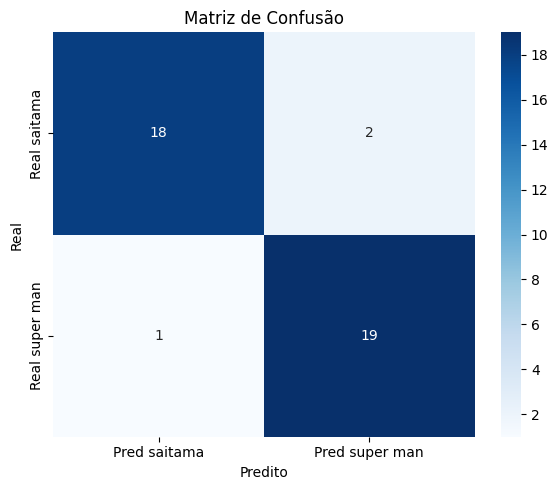


--- TESTE EM NOVAS IMAGENS (SIMULAÇÃO) ---


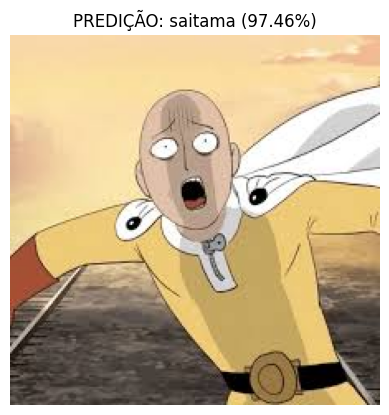

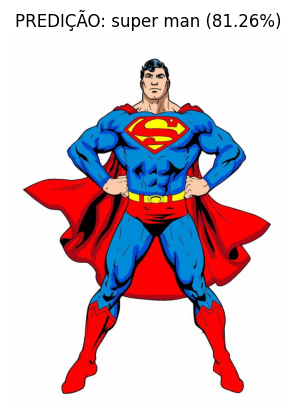

In [14]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms, models
import random
import time
import copy

# --- FUNÇÕES ESSENCIAIS DE ETAPAS ANTERIORES ---

class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {f'{classe1}': 0, f'{classe2}': 1}

        for class_name, idx in self.class_to_idx.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    fpath = os.path.join(class_path, filename)
                    if os.path.isfile(fpath):
                        self.image_paths.append(fpath)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

        except Exception:
            new_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(new_idx)

def get_transforms(image_size=224):
    train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transforms, val_transforms

def create_dataloaders(root_dir, batch_size=32, image_size=224):
    train_dir = os.path.join(root_dir, "train")
    val_dir = os.path.join(root_dir, "val")
    train_transforms, val_transforms = get_transforms(image_size)

    try:
        train_dataset = AnimeDataset(root_dir=train_dir, transform=train_transforms)
        val_dataset = AnimeDataset(root_dir=val_dir, transform=val_transforms)

        if len(train_dataset) == 0 or len(val_dataset) == 0:
             raise ValueError("Dataset vazio.")

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        return train_dataloader, val_dataloader

    except Exception:
        return None, None

def setup_model(num_classes=2, feature_extract=False):
    model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

# --- FUNÇÕES DE INFERÊNCIA E AVALIAÇÃO ---

def evaluate_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    TN, FP, FN, TP = cm.ravel()

    metrics = {
        f"Verdadeiro {classe1} (TP)": TP,
        f"Verdadeiro {classe2} (TN)": TN,
        f"Falso {classe1} (FP)": FP,
        f"Falso {classe2} (FN)": FN
    }



    report = classification_report(all_labels, all_preds, target_names=[classe1, classe2])

    return total_acc.item(), total_loss, cm, metrics, report

def plot_confusion_matrix(cm, class_names=[f'{classe1}', f'{classe2}']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[f'Pred {c}' for c in class_names],
        yticklabels=[f'Real {c}' for c in class_names]
    )
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

def test_new_image(model, image_path, class_names=[f'{classe1}', f'{classe2}']):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    _, val_transforms = get_transforms(image_size=224)

    try:
        image = Image.open(image_path).convert('RGB')
    except:
        return

    input_tensor = val_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        _, predicted_class_idx = torch.max(output, 1)

    predicted_label = class_names[predicted_class_idx.item()]
    confidence = probabilities[predicted_class_idx.item()].item() * 100

    plt.imshow(image)
    plt.title(f"PREDIÇÃO: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

if __name__ == '__main__':

    DATA_DIR = f"/content/data/{tema}_split"
    NUM_CLASSES = 2

    _, val_loader = create_dataloaders(DATA_DIR, batch_size=32)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # --- CARREGA O MELHOR MODELO TREINADO ---
    modelo_final = setup_model(num_classes=2, feature_extract=True)
    modelo_final.load_state_dict(torch.load("best_model.pth", map_location=device))
    modelo_final.to(device)
    modelo_final.eval()

    print("--- INFERÊNCIA NO CONJUNTO DE VALIDAÇÃO ---")

    if val_loader:
        acc, loss, cm, metrics, report = evaluate_model(modelo_final, val_loader)

        print(f"Loss na Validação: {loss:.4f}")
        print(f"Acurácia na Validação: {acc:.4f} ({acc*100:.2f}%)\n")

        print("===== MATRIZ DE CONFUSÃO =====")
        print(cm)

        print("\n===== DETALHAMENTO =====")
        for k, v in metrics.items():
            print(f"{k}: {v}")

        print("\n===== RELATÓRIO COMPLETO =====")
        print(report)

        plot_confusion_matrix(cm)

    print("\n--- TESTE EM NOVAS IMAGENS (SIMULAÇÃO) ---")

    imagens_teste_simuladas = [
        out1,
        out2
    ]
    if not any(os.path.exists(p) for p in imagens_teste_simuladas):
        print("Nenhum caminho de imagem de teste externo válido. Teste ignorado.")
    else:
        for img_path in imagens_teste_simuladas:
            if os.path.exists(img_path):
                test_new_image(modelo_final, img_path)



In [15]:
!apt-get install tree


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (62.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [16]:
!tree -L 3 /content/data


/content/data
├── herois
│   ├── saitama
│   │   ├── 000001.jpg
│   │   ├── 000002.jpg
│   │   ├── 000003.jpg
│   │   ├── 000004.jpg
│   │   ├── 000005.jpg
│   │   ├── 000006.jpg
│   │   ├── 000007.jpg
│   │   ├── 000008.jpg
│   │   ├── 000009.jpg
│   │   ├── 000010.jpg
│   │   ├── 000011.jpg
│   │   ├── 000012.jpg
│   │   ├── 000013.jpg
│   │   ├── 000014.jpg
│   │   ├── 000015.jpg
│   │   ├── 000016.jpg
│   │   ├── 000017.jpg
│   │   ├── 000018.jpg
│   │   ├── 000019.jpg
│   │   ├── 000020.jpg
│   │   ├── 000021.jpg
│   │   ├── 000022.jpg
│   │   ├── 000023.jpg
│   │   ├── 000024.jpg
│   │   ├── 000025.jpg
│   │   ├── 000026.jpg
│   │   ├── 000027.jpg
│   │   ├── 000028.jpg
│   │   ├── 000029.jpg
│   │   ├── 000030.jpg
│   │   ├── 000031.jpg
│   │   ├── 000032.jpg
│   │   ├── 000033.jpg
│   │   ├── 000034.jpg
│   │   ├── 000035.jpg
│   │   ├── 000036.jpg
│   │   ├── 000037.jpg
│   │   ├── 000038.jpg
│   │   ├── 000039.jpg
│   │   ├── 000040.jpg
│   │   ├── 000041.jpg
│   │   ├── 0000

In [17]:
import os

def contar(pasta):
    return len(os.listdir(pasta))

print(f"Train {classe1}:", contar(f"/content/data/{tema}_split/train/{classe1}"))
print(f"Train {classe1}:", contar(f"/content/data/{tema}_split/train/{classe2}"))
print(f"Val {classe1}:", contar(f"/content/data/{tema}_split/val/{classe1}"))
print(f"Val {classe2}:", contar(f"/content/data/{tema}_split/val/{classe2}"))


Train saitama: 80
Train saitama: 80
Val saitama: 20
Val super man: 20
